In [2]:
# Download the data stored in a zipped numpy array from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo" -O training_images.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/i0apaktucm7y4od7k4ux69k8t1iue7w8" -O test_images.npz

# The example images are here
!wget "https://sussex.box.com/shared/static/aulkv3tf2fc0765yqgfm9am87vgn3p8a" -O examples.npz


--2024-05-16 12:24:15--  https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.box.com (sussex.box.com)... 74.112.186.144
Connecting to sussex.box.com (sussex.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-16 12:24:15--  https://sussex.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-16 12:24:16--  https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.144
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://euc1.b

In [3]:
import numpy as np


# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)

(2811, 256, 256, 3) (2811, 44, 2)
(554, 256, 256, 3)
(6, 256, 256, 3)


This is my final model used on the test images

In [16]:
# Import necessary libraries
import cv2  # OpenCV library for image processing
import numpy as np  # NumPy for array operations
from sklearn.ensemble import RandomForestRegressor  # RandomForestRegressor for regression model
from sklearn.model_selection import train_test_split  # Train-test split
from sklearn.metrics import mean_squared_error  # MSE for error evaluation
from sklearn.decomposition import PCA  # PCA for dimensionality reduction
from keras.preprocessing.image import ImageDataGenerator  # ImageDataGenerator for data augmentation

# Function to get an image data generator with specified augmentation parameters
def get_data_generator():
    return ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Function to preprocess images (resize, convert to grayscale, and normalize)
def preprocess_images(images, target_size=(256, 256)):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, target_size)  # Resize image
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img_normalized = img_gray / 255.0  # Normalize pixel values
        processed_images.append(img_normalized)
    return np.array(processed_images)

# Function to augment images using data generator
def augment_images(images):
    data_generator = get_data_generator()
    augmented_images = []
    for image in images:
        image = image.reshape((1,) + image.shape + (1,))  # Reshape for data generator
        for augmented_image in data_generator.flow(image, batch_size=1):
            augmented_images.append(augmented_image[0, :, :, 0])
            if len(augmented_images) >= len(images):  # Stop once enough images are generated
                break
    return np.array(augmented_images[:len(images)])

# Function to extract features using SIFT (Scale-Invariant Feature Transform)
def extract_features(images, max_features=500, scale_factor=1.6, num_scales=5):
    sift = cv2.SIFT_create(nOctaveLayers=num_scales)
    enhanced_features = []
    for image in images:
        image_8bit = (image * 255).astype(np.uint8)  # Convert to 8-bit image
        keypoints = sift.detect(image_8bit, None)  # Detect keypoints
        keypoints = [cv2.KeyPoint(x.pt[0] * scale_factor, x.pt[1] * scale_factor, x.size * scale_factor) for x in keypoints]
        _, descriptors = sift.compute(image_8bit, keypoints)  # Compute descriptors
        descriptors = descriptors if descriptors is not None else np.zeros((0, 128))

        # Pad or truncate descriptors to ensure consistent feature vector length
        if descriptors.shape[0] < max_features:
            pad_length = max_features - descriptors.shape[0]
            padded_descriptors = np.pad(descriptors, ((0, pad_length), (0, 0)), 'constant')
        else:
            padded_descriptors = descriptors[:max_features]

        feature_vector = padded_descriptors.flatten()[:max_features * 128]
        enhanced_features.append(feature_vector)
    return np.array(enhanced_features)

# Function to train a regression model (Random Forest) and return details
def train_regression_model_and_return_details(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    pca = PCA(n_components=100)
    X_train_reduced = pca.fit_transform(X_train)
    X_val_reduced = pca.transform(X_val)

    model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1)
    model.fit(X_train_reduced, y_train)
    predictions = model.predict(X_val_reduced)
    mse = mean_squared_error(y_val, predictions)
    return model, pca, mse, y_val, predictions

# Function to load and preprocess data
def load_and_preprocess_data():
    data = np.load('training_images.npz', allow_pickle=True)  # Load data
    images = data['images']
    points = data['points']
    points_flattened = points.reshape(points.shape[0], -1)  # Flatten points for regression
    return images, points_flattened

# Main function to execute the face alignment process
def main():
    images, points_flattened = load_and_preprocess_data()
    images_preprocessed = preprocess_images(images)
    images_augmented = augment_images(images_preprocessed)
    features = extract_features(images_augmented)

    rf_model, pca, rf_mse, y_val, predictions = train_regression_model_and_return_details(features, points_flattened)

    errors = np.sqrt(np.sum(np.square(y_val - predictions), axis=1))  # Compute errors
    return errors

# Run the main function and print the mean error
if __name__ == "__main__":
    rf_errors = main()
    print(f"Random Forest Model Mean Error: {np.mean(rf_errors)}")


Random Forest Model Mean Error: 97.33568332600724


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

def load_and_preprocess_data():
    # Load data
    data = np.load('training_images.npz', allow_pickle=True)
    images = data['images'].astype(np.float32) / 255.0  # Normalize images
    points = data['points'].astype(np.float32)

    # Flatten points from [num_samples, 44, 2] to [num_samples, 88]
    points_flattened = points.reshape((points.shape[0], -1))

    return images, points_flattened


def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(88)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def main():
    images, points_flattened = load_and_preprocess_data()
    model = build_model(images.shape[1:])  # shape[1:] passes (height, width, channels)

    # Split data into training and validation sets
    split_idx = int(len(images) * 0.8)
    train_images, val_images = images[:split_idx], images[split_idx:]
    train_points, val_points = points_flattened[:split_idx], points_flattened[split_idx:]

    # Train the model
    history = model.fit(train_images, train_points, epochs=50,
                        validation_data=(val_images, val_points), batch_size=32)

    # Evaluate the model
    print("Training completed. Evaluating model...")
    val_loss = model.evaluate(val_images, val_points)
    print(f"Validation Loss: {val_loss}")


if __name__ == "__main__":
    main()





Epoch 1/50
71/71 [==============================] - 8s 94ms/step - loss: 2456.4751 - val_loss: 204.5612
Epoch 2/50
71/71 [==============================] - 6s 78ms/step - loss: 540.6458 - val_loss: 183.0540
Epoch 3/50
71/71 [==============================] - 6s 79ms/step - loss: 433.2126 - val_loss: 194.7185
Epoch 4/50
71/71 [==============================] - 6s 79ms/step - loss: 377.2011 - val_loss: 221.3331
Epoch 5/50
71/71 [==============================] - 6s 79ms/step - loss: 327.4294 - val_loss: 126.7382
Epoch 6/50
71/71 [==============================] - 6s 80ms/step - loss: 301.3104 - val_loss: 117.6570
Epoch 7/50
71/71 [==============================] - 6s 79ms/step - loss: 282.3083 - val_loss: 113.1043
Epoch 8/50
71/71 [==============================] - 6s 79ms/step - loss: 260.5272 - val_loss: 113.5218
Epoch 9/50
71/71 [==============================] - 6s 79ms/step - loss: 244.4679 - val_loss: 88.9034
Epoch 10/50
71/71 [==============================] - 6s 79ms/step - loss:

Epoch 1/50
71/71 [==============================] - 15s 185ms/step - loss: 3320.0793 - val_loss: 8862.5859
Epoch 2/50
71/71 [==============================] - 12s 169ms/step - loss: 1974.1693 - val_loss: 2842.5510
Epoch 3/50
71/71 [==============================] - 12s 170ms/step - loss: 1560.2592 - val_loss: 1391.2985
Epoch 4/50
71/71 [==============================] - 12s 169ms/step - loss: 1318.3948 - val_loss: 1590.6768
Epoch 5/50
71/71 [==============================] - 12s 169ms/step - loss: 1046.2351 - val_loss: 2110.1877
Epoch 6/50
71/71 [==============================] - 12s 169ms/step - loss: 902.2352 - val_loss: 2185.8167
Epoch 7/50
71/71 [==============================] - 12s 169ms/step - loss: 740.5562 - val_loss: 1599.9130
Epoch 8/50
71/71 [==============================] - 12s 169ms/step - loss: 711.6242 - val_loss: 1778.5985
Epoch 9/50
71/71 [==============================] - 12s 169ms/step - loss: 631.0154 - val_loss: 311.7408
Epoch 10/50
71/71 [=======================

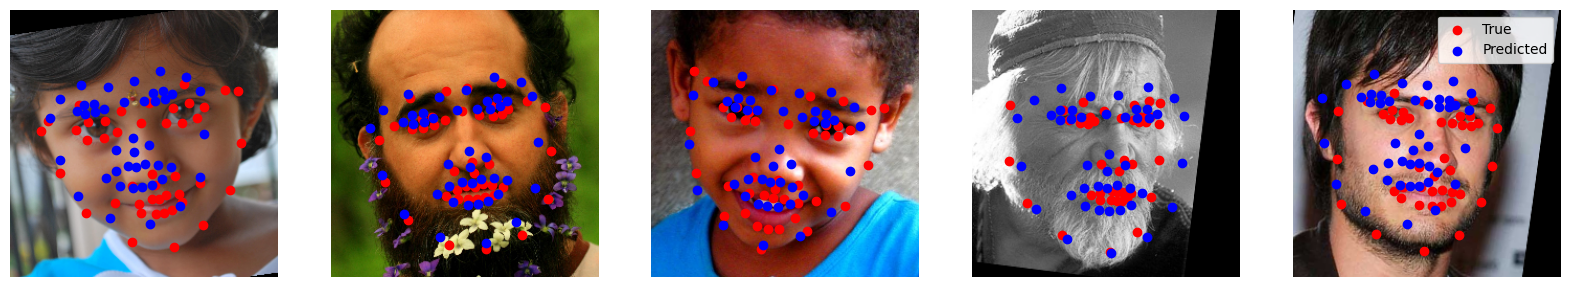

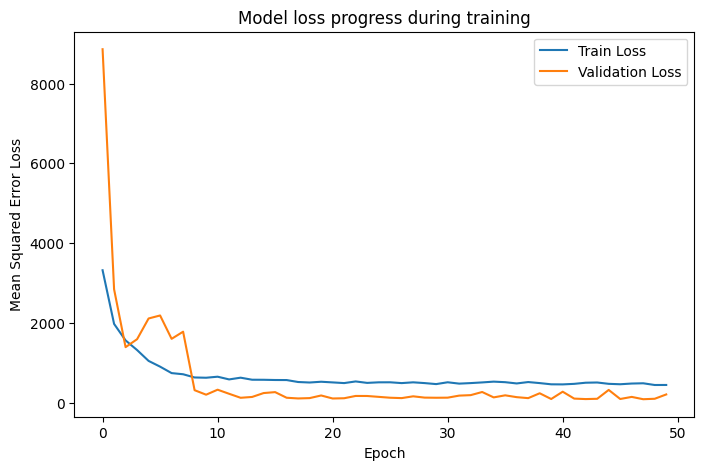

In [5]:
import matplotlib.pyplot as plt

def plot_results(images, true_points, predicted_points, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.scatter(true_points[i, ::2], true_points[i, 1::2], color='red', label='True')
        ax.scatter(predicted_points[i, ::2], predicted_points[i, 1::2], color='blue', label='Predicted')
        ax.axis('off')
    plt.legend()
    plt.show()

def main():
    images, points_flattened = load_and_preprocess_data()
    model = build_model(images.shape[1:])

    # Train and validate model
    split_idx = int(len(images) * 0.8)
    train_images, val_images = images[:split_idx], images[split_idx:]
    train_points, val_points = points_flattened[:split_idx], points_flattened[split_idx:]
    history = model.fit(train_images, train_points, epochs=50,
                        validation_data=(val_images, val_points), batch_size=32)

    # Evaluate the model
    val_loss = model.evaluate(val_images, val_points)
    print(f"Validation Loss: {val_loss}")

    # Predict on validation set for visualization
    predicted_points = model.predict(val_images)
    plot_results(val_images[:5], val_points[:5], predicted_points[:5])

    # Plot training & validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training')
    plt.ylabel('Mean Squared Error Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

Epoch 1/50
71/71 [==============================] - 8s 93ms/step - loss: 2436.3738 - val_loss: 362.6851
Epoch 2/50
71/71 [==============================] - 6s 78ms/step - loss: 567.2953 - val_loss: 164.8214
Epoch 3/50
71/71 [==============================] - 6s 78ms/step - loss: 437.4319 - val_loss: 245.3336
Epoch 4/50
71/71 [==============================] - 6s 79ms/step - loss: 368.7715 - val_loss: 138.3921
Epoch 5/50
71/71 [==============================] - 6s 79ms/step - loss: 329.9692 - val_loss: 125.6398
Epoch 6/50
71/71 [==============================] - 6s 79ms/step - loss: 295.0346 - val_loss: 186.5058
Epoch 7/50
71/71 [==============================] - 6s 79ms/step - loss: 264.9447 - val_loss: 158.7510
Epoch 8/50
71/71 [==============================] - 6s 79ms/step - loss: 260.2737 - val_loss: 109.0631
Epoch 9/50
71/71 [==============================] - 6s 79ms/step - loss: 232.1078 - val_loss: 153.5259
Epoch 10/50
71/71 [==============================] - 6s 79ms/step - loss

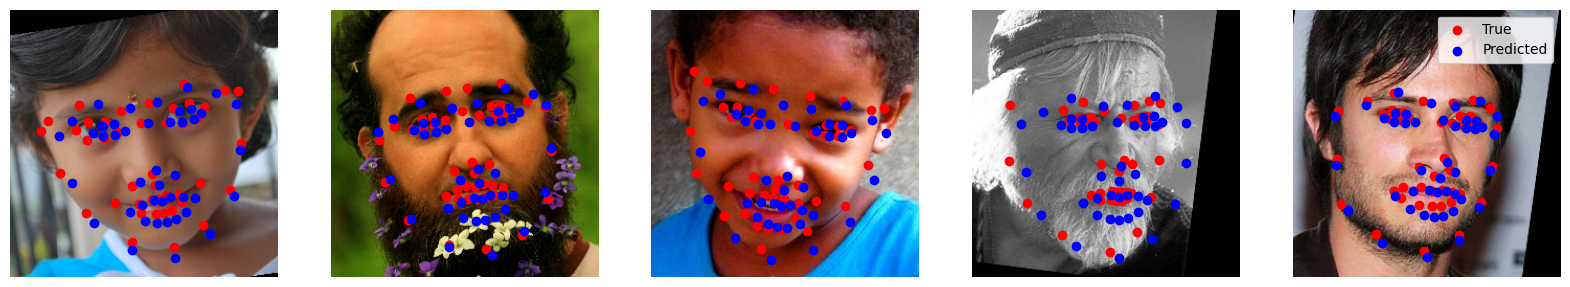

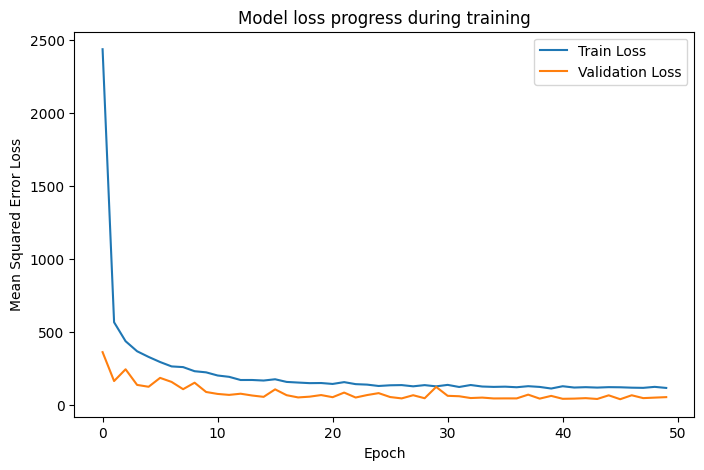

In [7]:
import matplotlib.pyplot as plt

def plot_results(images, true_points, predicted_points, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.scatter(true_points[i, ::2], true_points[i, 1::2], color='red', label='True')
        ax.scatter(predicted_points[i, ::2], predicted_points[i, 1::2], color='blue', label='Predicted')
        ax.axis('off')
    plt.legend()
    plt.show()

def main():
    images, points_flattened = load_and_preprocess_data()
    model = build_model(images.shape[1:])

    # Train and validate model
    split_idx = int(len(images) * 0.8)
    train_images, val_images = images[:split_idx], images[split_idx:]
    train_points, val_points = points_flattened[:split_idx], points_flattened[split_idx:]
    history = model.fit(train_images, train_points, epochs=50,
                        validation_data=(val_images, val_points), batch_size=32)

    # Evaluate the model
    val_loss = model.evaluate(val_images, val_points)
    print(f"Validation Loss: {val_loss}")

    # Predict on validation set for visualization
    predicted_points = model.predict(val_images)
    plot_results(val_images[:5], val_points[:5], predicted_points[:5])

    # Plot training & validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training')
    plt.ylabel('Mean Squared Error Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

Epoch 1/50
71/71 [==============================] - 8s 94ms/step - loss: 2404.4980 - val_loss: 222.7521
Epoch 2/50
71/71 [==============================] - 6s 79ms/step - loss: 540.1460 - val_loss: 143.6782
Epoch 3/50
71/71 [==============================] - 6s 79ms/step - loss: 441.0447 - val_loss: 149.8553
Epoch 4/50
71/71 [==============================] - 6s 80ms/step - loss: 352.7535 - val_loss: 140.0317
Epoch 5/50
71/71 [==============================] - 6s 80ms/step - loss: 310.9953 - val_loss: 131.2240
Epoch 6/50
71/71 [==============================] - 6s 80ms/step - loss: 291.2134 - val_loss: 118.6881
Epoch 7/50
71/71 [==============================] - 6s 80ms/step - loss: 262.9226 - val_loss: 108.5370
Epoch 8/50
71/71 [==============================] - 6s 79ms/step - loss: 250.1035 - val_loss: 102.4124
Epoch 9/50
71/71 [==============================] - 6s 79ms/step - loss: 229.2423 - val_loss: 154.6001
Epoch 10/50
71/71 [==============================] - 6s 79ms/step - loss

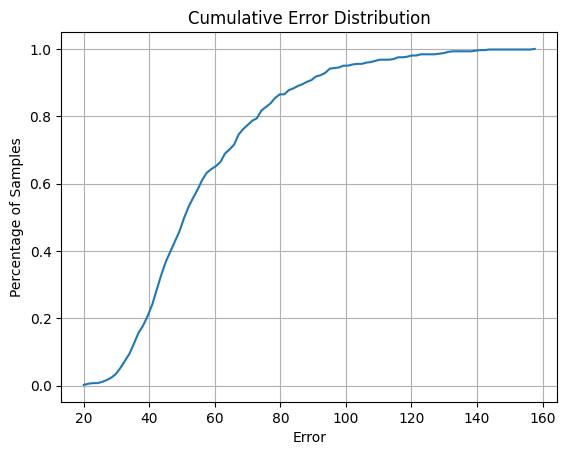

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def load_and_preprocess_data():
    data = np.load('training_images.npz', allow_pickle=True)
    images = data['images'].astype(np.float32) / 255.0
    points = data['points'].astype(np.float32)
    points_flattened = points.reshape((points.shape[0], -1))
    return images, points_flattened

def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(88)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def calculate_errors(val_points, predicted_points):
    # Calculate Euclidean distance error for each point pair
    errors = np.sqrt(np.sum(np.square(val_points - predicted_points), axis=1))
    return errors

def plot_ced(errors):
    counts, bin_edges = np.histogram(errors, bins=100, density=True)
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[1:], cdf / cdf[-1])
    plt.title('Cumulative Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Percentage of Samples')
    plt.grid(True)
    plt.show()

def main():
    images, points_flattened = load_and_preprocess_data()
    model = build_model(images.shape[1:])

    # Split data into training and validation sets
    split_idx = int(len(images) * 0.8)
    train_images, val_images = images[:split_idx], images[split_idx:]
    train_points, val_points = points_flattened[:split_idx], points_flattened[split_idx:]

    # Train the model
    history = model.fit(train_images, train_points, epochs=50, validation_data=(val_images, val_points), batch_size=32)

    # Evaluate the model
    print("Training completed. Evaluating model...")
    val_loss = model.evaluate(val_images, val_points)
    print(f"Validation Loss: {val_loss}")

    # Predict on validation set
    predicted_points = model.predict(val_images)

    # Calculate errors
    errors = calculate_errors(val_points, predicted_points)

    # Plot Cumulative Error Distribution
    plot_ced(errors)

if __name__ == "__main__":
    main()



In [9]:
import cv2
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from joblib import dump

def preprocess_images(images, target_size=(256, 256)):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, target_size)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_normalized = img_gray / 255.0
        processed_images.append(img_normalized)
    return np.array(processed_images)

import cv2
import numpy as np

def extract_features(images, max_features=500, scale_factor=1.6, num_scales=5):
    sift = cv2.SIFT_create(nOctaveLayers=num_scales)
    enhanced_features = []
    for image in images:
        image_8bit = (image * 255).astype(np.uint8)
        keypoints = sift.detect(image_8bit, None)
        keypoints = [cv2.KeyPoint(x.pt[0] * scale_factor, x.pt[1] * scale_factor, x.size * scale_factor) for x in keypoints]
        _, descriptors = sift.compute(image_8bit, keypoints)
        descriptors = descriptors if descriptors is not None else np.zeros((0, 128))

        # Ensure each descriptor is padded to max_features length
        if descriptors.shape[0] < max_features:
            pad_length = max_features - descriptors.shape[0]
            padded_descriptors = np.pad(descriptors, ((0, pad_length), (0, 0)), 'constant')
        else:
            padded_descriptors = descriptors[:max_features]

        # Flatten the descriptors and ensure all are the same length
        feature_vector = padded_descriptors.flatten()[:max_features * 128]  # Keep vector length consistent
        enhanced_features.append(feature_vector)

    return np.array(enhanced_features)

def train_regression_model_and_return_details(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    pca = PCA(n_components=100)
    X_train_reduced = pca.fit_transform(X_train)
    X_val_reduced = pca.transform(X_val)

    model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10,
                                  min_samples_leaf=4, random_state=42, n_jobs=-1)
    model.fit(X_train_reduced, y_train)
    predictions = model.predict(X_val_reduced)
    mse = mean_squared_error(y_val, predictions)
    return model, pca, mse  # Return all relevant details



images_preprocessed = preprocess_images(images)
features = extract_features(images_preprocessed)
pts_flattened = pts.reshape(pts.shape[0], -1)

# Correctly handle the returned values
model, pca, mse = train_regression_model_and_return_details(features, pts_flattened)
print(f"Mean Squared Error: {mse}")




Mean Squared Error: 125.62150439126145


In [11]:


# Preprocess images
images_preprocessed = preprocess_images(images)
# Extract features
features = extract_features(images_preprocessed)
# Flatten points
pts_flattened = pts.reshape(pts.shape[0], -1)

# Train and predict
best_model, pca, mse = train_regression_model_and_return_details(features, pts_flattened)
print(f"Mean Squared Error: {mse}")

# Predict points using the trained model
predicted_points = best_model.predict(pca.transform(extract_features(preprocess_images(images))))

# Calculate errors
def calculate_errors(pts, predicted_points):
    # Reshape points for comparison
    val_points_reshaped = pts.reshape(pts.shape[0], 44, 2)
    predicted_points_reshaped = predicted_points.reshape(predicted_points.shape[0], 44, 2)

    # Calculate Euclidean distances for each point pair
    errors = np.sqrt(np.sum((val_points_reshaped - predicted_points_reshaped)**2, axis=2))
    mean_errors = np.mean(errors, axis=1)  # Mean error per image
    return mean_errors

errors_rf = calculate_errors(pts, predicted_points)
print(f"Errors: {errors_rf}")


Mean Squared Error: 125.57289992745076
Errors: [5.56888768 6.14733803 8.02214545 ... 6.8042881  5.02565765 9.65632659]


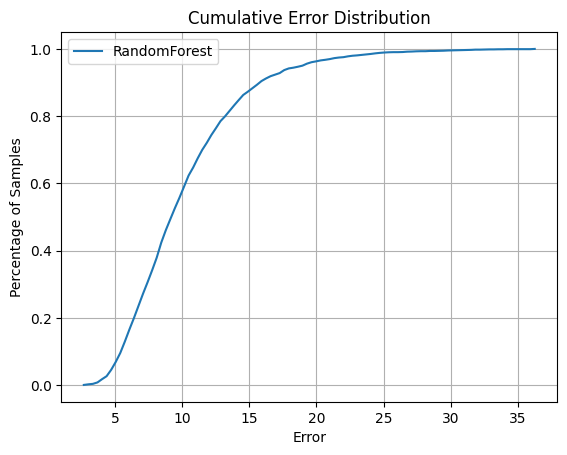

In [12]:
def plot_ced(errors, title='Cumulative Error Distribution'):
    counts, bin_edges = np.histogram(errors, bins=100, density=True)
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[1:], cdf/cdf[-1], label='RandomForest')
    plt.title(title)
    plt.xlabel('Error')
    plt.ylabel('Percentage of Samples')
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot CED for RandomForest model
plot_ced(errors_rf)


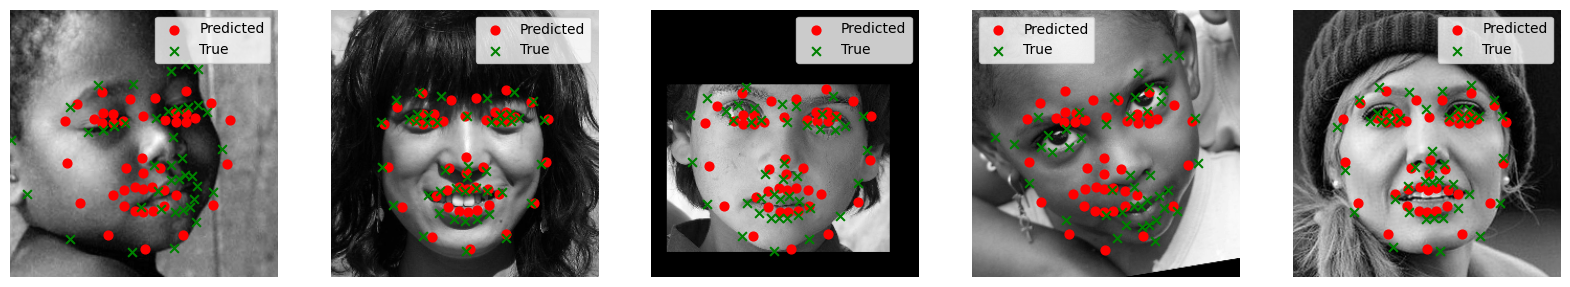

In [41]:
import matplotlib.pyplot as plt
import random

def plot_landmarks(images, predicted_pts, true_pts=None, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')
        pred_points = predicted_pts[i].reshape(-1, 2)
        ax.scatter(pred_points[:, 0], pred_points[:, 1], c='r', label='Predicted', s=40)
        if true_pts is not None:
            true_points = true_pts[i].reshape(-1, 2)
            ax.scatter(true_points[:, 0], true_points[:, 1], c='g', label='True', s=40, marker='x')
        ax.axis('off')
        ax.legend()
    plt.show()

# Select a random subset of the preprocessed images
num_images_to_plot = 5
random_indices = random.sample(range(images_preprocessed.shape[0]), num_images_to_plot)
images_subset = images_preprocessed[random_indices]
true_pts_subset = pts[random_indices].reshape(num_images_to_plot, -1)

# Extract features for these images
features_subset = extract_features(images_subset)

# Reduce dimensionality of these features using PCA
features_subset_reduced = pca.transform(features_subset)

# Predict landmarks
predicted_pts_subset = model.predict(features_subset_reduced)

# Plot the images with the predicted landmarks
plot_landmarks(images_subset, predicted_pts_subset, true_pts_subset, num_images=num_images_to_plot)



In [24]:
import numpy as np
import cv2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from keras.preprocessing.image import ImageDataGenerator

def get_data_generator():
    return ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

def preprocess_images(images, target_size=(256, 256)):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, target_size)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_normalized = img_gray / 255.0
        processed_images.append(img_normalized)
    return np.array(processed_images)

def augment_images(images):
    data_generator = get_data_generator()
    augmented_images = []
    for image in images:
        image = image.reshape((1,) + image.shape + (1,))  # Reshape to (1, height, width, 1)
        for augmented_image in data_generator.flow(image, batch_size=1):
            augmented_images.append(augmented_image[0, :, :, 0])
            if len(augmented_images) >= len(images):  # Generate only as many augmented images as the original set
                break
    return np.array(augmented_images[:len(images)])

def extract_features(images, max_features=500, scale_factor=1.6, num_scales=5):
    sift = cv2.SIFT_create(nOctaveLayers=num_scales)
    enhanced_features = []
    for image in images:
        image_8bit = (image * 255).astype(np.uint8)
        keypoints = sift.detect(image_8bit, None)
        keypoints = [cv2.KeyPoint(x.pt[0] * scale_factor, x.pt[1] * scale_factor, x.size * scale_factor) for x in keypoints]
        _, descriptors = sift.compute(image_8bit, keypoints)
        descriptors = descriptors if descriptors is not None else np.zeros((0, 128))

        if descriptors.shape[0] < max_features:
            pad_length = max_features - descriptors.shape[0]
            padded_descriptors = np.pad(descriptors, ((0, pad_length), (0, 0)), 'constant')
        else:
            padded_descriptors = descriptors[:max_features]

        feature_vector = padded_descriptors.flatten()[:max_features * 128]
        enhanced_features.append(feature_vector)
    return np.array(enhanced_features)

def train_regression_model_and_return_details(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    pca = PCA(n_components=100)
    X_train_reduced = pca.fit_transform(X_train)
    X_val_reduced = pca.transform(X_val)

    model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1)
    model.fit(X_train_reduced, y_train)
    predictions = model.predict(X_val_reduced)
    mse = mean_squared_error(y_val, predictions)
    return model, pca, mse, y_val, predictions

def save_as_csv(points, location='.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0] == 554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:]) == 44 * 2, 'wrong number of points provided. There should be 44 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

def load_and_preprocess_data():
    # Load the data using np.load
    data = np.load('training_images.npz', allow_pickle=True)
    images = data['images']
    points = data['points']
    points_flattened = points.reshape(points.shape[0], -1)
    return images, points_flattened

def main():
    # Load and preprocess training data
    images, points_flattened = load_and_preprocess_data()
    images_preprocessed = preprocess_images(images)
    images_augmented = augment_images(images_preprocessed)
    features = extract_features(images_augmented)

    # Train model
    rf_model, pca, rf_mse, y_val, predictions = train_regression_model_and_return_details(features, points_flattened)
    print(f"Random Forest Model Mean Error: {rf_mse}")

    # Load and preprocess test images
    test_data = np.load('test_images.npz', allow_pickle=True)
    test_images = test_data['images']
    test_images_preprocessed = preprocess_images(test_images)
    test_images_augmented = augment_images(test_images_preprocessed)
    test_features = extract_features(test_images_augmented)

    # Predict on test images
    test_features_reduced = pca.transform(test_features)
    test_predictions = rf_model.predict(test_features_reduced)
    test_predictions_reshaped = test_predictions.reshape(test_images.shape[0], 44, 2)

    # Save predictions to CSV
    save_as_csv(test_predictions_reshaped)

if __name__ == "__main__":
    main()


Random Forest Model Mean Error: 130.87236621702874


Random Forest Model Mean Error: 97.337543007168
Example Image Predictions:
[[ 50.17518095 108.08465841  54.14783766 149.38978653  67.96025966
  187.4795143   96.76644022 216.36046686 132.89250524 229.09297479
  167.73691967 213.68452307 194.4230161  183.21121843 205.67549672
  143.84516274 207.09785847 102.58866407  63.35200288  91.67792737
   86.83402444  79.62455364 114.37257575  86.54642654 139.23507681
   84.92639388 167.05951456  76.40187295 190.97789029  86.99229457
  127.84285406 102.16507306 129.20141574 142.60014939 113.11984009
  152.09508904 129.5077669  156.97112477 145.19401961 151.26631103
   79.83570299 105.34569078  88.26069446 100.15016044  98.56370116
  100.09427077 107.46442504 106.47811231  98.40992281 108.51813325
   88.1173298  108.81647129 147.99175414 104.95541076 156.93250095
   97.71365712 167.09778348  97.41393042 175.63468748 102.02417968
  168.15266993 105.78798731 158.11664764 106.34486886 100.05004704
  177.72078365 111.1563495  172.71234461 122.36020373 

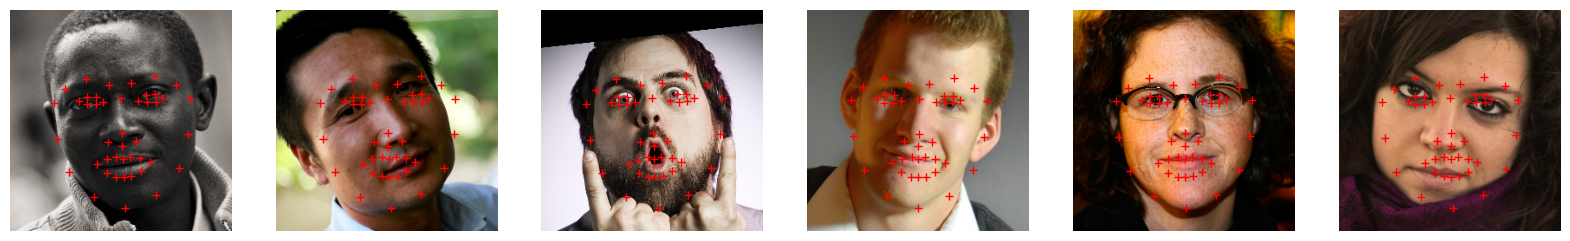

In [42]:
import numpy as np
import cv2
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the existing functions
def get_data_generator():
    return ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

def preprocess_images(images, target_size=(256, 256)):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, target_size)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_normalized = img_gray / 255.0
        processed_images.append(img_normalized)
    return np.array(processed_images)

def augment_images(images):
    data_generator = get_data_generator()
    augmented_images = []
    for image in images:
        image = image.reshape((1,) + image.shape + (1,))  # Reshape to (1, height, width, 1)
        for augmented_image in data_generator.flow(image, batch_size=1):
            augmented_images.append(augmented_image[0, :, :, 0])
            if len(augmented_images) >= len(images):  # Generate only as many augmented images as the original set
                break
    return np.array(augmented_images[:len(images)])

def extract_features(images, max_features=500, scale_factor=1.6, num_scales=5):
    sift = cv2.SIFT_create(nOctaveLayers=num_scales)
    enhanced_features = []
    for image in images:
        image_8bit = (image * 255).astype(np.uint8)
        keypoints = sift.detect(image_8bit, None)
        keypoints = [cv2.KeyPoint(x.pt[0] * scale_factor, x.pt[1] * scale_factor, x.size * scale_factor) for x in keypoints]
        _, descriptors = sift.compute(image_8bit, keypoints)
        descriptors = descriptors if descriptors is not None else np.zeros((0, 128))

        if descriptors.shape[0] < max_features:
            pad_length = max_features - descriptors.shape[0]
            padded_descriptors = np.pad(descriptors, ((0, pad_length), (0, 0)), 'constant')
        else:
            padded_descriptors = descriptors[:max_features]

        feature_vector = padded_descriptors.flatten()[:max_features * 128]
        enhanced_features.append(feature_vector)
    return np.array(enhanced_features)

def load_and_preprocess_data():
    # Load the data using np.load
    data = np.load('training_images.npz', allow_pickle=True)
    images = data['images']
    points = data['points']
    points_flattened = points.reshape(points.shape[0], -1)
    return images, points_flattened

def train_regression_model_and_return_details(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    pca = PCA(n_components=100)
    X_train_reduced = pca.fit_transform(X_train)
    X_val_reduced = pca.transform(X_val)

    model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1)
    model.fit(X_train_reduced, y_train)
    predictions = model.predict(X_val_reduced)
    mse = mean_squared_error(y_val, predictions)
    return model, pca, mse, y_val, predictions

def main():
    images, points_flattened = load_and_preprocess_data()
    images_preprocessed = preprocess_images(images)
    images_augmented = augment_images(images_preprocessed)
    features = extract_features(images_augmented)

    rf_model, pca, rf_mse, y_val, predictions = train_regression_model_and_return_details(features, points_flattened)

    errors = np.sqrt(np.sum(np.square(y_val - predictions), axis=1))
    return rf_model, pca, errors

# New function to process example images
def process_example_images(model, pca):
    example_data = np.load('examples.npz', allow_pickle=True)
    example_images = example_data['images']

    example_images_preprocessed = preprocess_images(example_images)
    example_images_augmented = augment_images(example_images_preprocessed)
    example_features = extract_features(example_images_augmented)

    example_features_reduced = pca.transform(example_features)
    example_predictions = model.predict(example_features_reduced)

    return example_images, example_predictions

def visualise_pts_in_row(images, pts):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')
        ax.plot(pts[i][:, 0], pts[i][:, 1], '+r')
        ax.axis('off')
    plt.show()

if __name__ == "__main__":
    rf_model, pca, rf_errors = main()
    print(f"Random Forest Model Mean Error: {np.mean(rf_errors)}")

    example_images, example_predictions = process_example_images(rf_model, pca)
    print("Example Image Predictions:")
    print(example_predictions)

    # Visualize the example images with predicted points in a row
    example_predictions_reshaped = [pts.reshape(-1, 2) for pts in example_predictions]
    visualise_pts_in_row(example_images, example_predictions_reshaped)


In [27]:
import numpy as np
import cv2
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

def get_data_generator():
    return ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

def preprocess_images(images, target_size=(256, 256)):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, target_size)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_normalized = img_gray / 255.0
        processed_images.append(img_normalized)
    return np.array(processed_images)

def augment_images(images):
    data_generator = get_data_generator()
    augmented_images = []
    for image in images:
        image = image.reshape((1,) + image.shape + (1,))  # Reshape to (1, height, width, 1)
        for augmented_image in data_generator.flow(image, batch_size=1):
            augmented_images.append(augmented_image[0, :, :, 0])
            if len(augmented_images) >= len(images):  # Generate only as many augmented images as the original set
                break
    return np.array(augmented_images[:len(images)])

def extract_features(images, max_features=500, scale_factor=1.6, num_scales=5):
    sift = cv2.SIFT_create(nOctaveLayers=num_scales)
    enhanced_features = []
    for image in images:
        image_8bit = (image * 255).astype(np.uint8)
        keypoints = sift.detect(image_8bit, None)
        keypoints = [cv2.KeyPoint(x.pt[0] * scale_factor, x.pt[1] * scale_factor, x.size * scale_factor) for x in keypoints]
        _, descriptors = sift.compute(image_8bit, keypoints)
        descriptors = descriptors if descriptors is not None else np.zeros((0, 128))

        if descriptors.shape[0] < max_features:
            pad_length = max_features - descriptors.shape[0]
            padded_descriptors = np.pad(descriptors, ((0, pad_length), (0, 0)), 'constant')
        else:
            padded_descriptors = descriptors[:max_features]

        feature_vector = padded_descriptors.flatten()[:max_features * 128]
        enhanced_features.append(feature_vector)
    return np.array(enhanced_features)

def train_regression_model_and_return_details(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    pca = PCA(n_components=100)
    X_train_reduced = pca.fit_transform(X_train)
    X_val_reduced = pca.transform(X_val)

    model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42, n_jobs=-1)
    model.fit(X_train_reduced, y_train)
    predictions = model.predict(X_val_reduced)
    mse = mean_squared_error(y_val, predictions)
    return model, pca, mse, y_val, predictions

def save_as_csv(points, filename='results.csv', location='.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param filename: Filename to save results.csv as.
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0] == 554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:]) == 44 * 2, 'wrong number of points provided. There should be 44 points with 2 values (x,y) per point'
    np.savetxt(f"{location}/{filename}", np.reshape(points, (points.shape[0], -1)), delimiter=',')
    print(f"CSV file saved at: {location}/{filename}")

def load_and_preprocess_data():
    # Load the data using np.load
    data = np.load('training_images.npz', allow_pickle=True)
    images = data['images']
    points = data['points']
    points_flattened = points.reshape(points.shape[0], -1)
    return images, points_flattened

def main():
    # Mount Google Drive
    drive.mount('/content/gdrive')
    save_location = '/content/gdrive/My Drive/'

    # Load and preprocess training data
    images, points_flattened = load_and_preprocess_data()
    images_preprocessed = preprocess_images(images)
    images_augmented = augment_images(images_preprocessed)
    features = extract_features(images_augmented)

    # Train model
    rf_model, pca, rf_mse, y_val, predictions = train_regression_model_and_return_details(features, points_flattened)
    print(f"Random Forest Model Mean Error: {rf_mse}")

    # Load and preprocess test images
    test_data = np.load('test_images.npz', allow_pickle=True)
    test_images = test_data['images']
    test_images_preprocessed = preprocess_images(test_images)
    test_images_augmented = augment_images(test_images_preprocessed)
    test_features = extract_features(test_images_augmented)

    # Predict on test images
    test_features_reduced = pca.transform(test_features)
    test_predictions = rf_model.predict(test_features_reduced)
    test_predictions_reshaped = test_predictions.reshape(test_images.shape[0], 44, 2)

    # Save predictions to CSV
    save_as_csv(test_predictions_reshaped, filename='results_new.csv', location=save_location)

if __name__ == "__main__":
    main()


Mounted at /content/gdrive
Random Forest Model Mean Error: 130.38888921424618
CSV file saved at: /content/gdrive/My Drive//results_new.csv


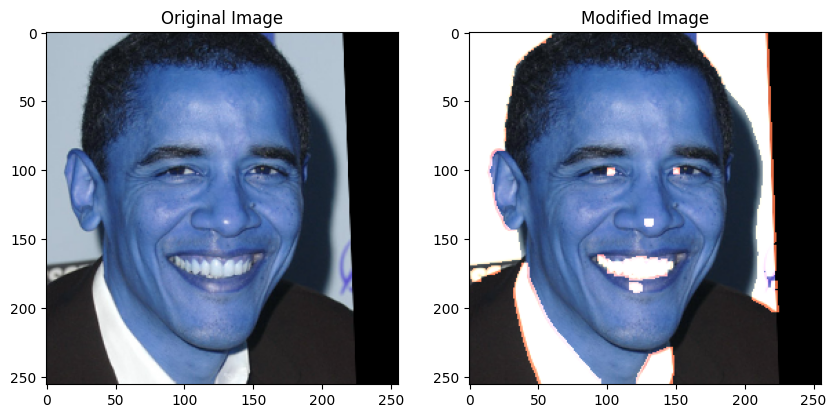

In [31]:
# Lip eye modifier

def apply_color_modification(image, target_lip_color=(255, 20, 147), target_eye_color=(65, 105, 225)):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color ranges for lips
    lower_lips = np.array([0, 100, 50])
    upper_lips = np.array([10, 255, 255])
    lip_mask = cv2.inRange(hsv_image, lower_lips, upper_lips)

    # Define color ranges for eyes
    lower_eyes = np.array([0, 0, 200])  # Looking for very light regions
    upper_eyes = np.array([180, 50, 255])
    eye_mask = cv2.inRange(hsv_image, lower_eyes, upper_eyes)

    # Morphological operations to clean up the masks
    kernel = np.ones((5, 5), np.uint8)
    lip_mask = cv2.dilate(lip_mask, kernel, iterations=1)
    eye_mask = cv2.dilate(eye_mask, kernel, iterations=1)

    # Convert masks to 3 channels
    lip_mask = cv2.cvtColor(lip_mask, cv2.COLOR_GRAY2BGR)
    eye_mask = cv2.cvtColor(eye_mask, cv2.COLOR_GRAY2BGR)

    # Apply the new colors to lips and eyes using bitwise operations
    lip_color_image = np.zeros_like(image)
    eye_color_image = np.zeros_like(image)

    lip_color_image[:] = target_lip_color
    eye_color_image[:] = target_eye_color

    lip_colored = cv2.bitwise_and(lip_color_image, lip_color_image, mask=lip_mask[:, :, 0])
    eye_colored = cv2.bitwise_and(eye_color_image, eye_color_image, mask=eye_mask[:, :, 0])

    # Add the colored regions back to the original image
    final_image = cv2.add(image, lip_colored)
    final_image = cv2.add(final_image, eye_colored)

    return final_image

# Example usage
index = 2  # Ensure this index is valid within your dataset
original_image = images[index]  # Assuming 'images' is loaded and in BGR format if using OpenCV
modified_image = apply_color_modification(original_image.copy())

# Display the modified image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
plt.title('Modified Image')
plt.show()
